In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU') # 내 컴에 장착된 GPU를 list로 반환
try:
    tf.config.experimental.set_memory_growth(gpu[0], True) # GPU Memory Growth를 Enable
except RuntimeError as e:
    print(e) # Error 발생하면 Error 내용 출력

In [2]:
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [3]:
import tensorflow.keras as keras
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob
import os
from tqdm import tqdm
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
tf.__version__

'2.4.0'

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6092045820543455528,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6871947673
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11720412321157113853
 physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5"]

In [6]:
w, h = 15, 15
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

file_list = glob('C:\jupyter_notebook\omok_AI_project\dataset_1515\*.npz')
# C:\jupyter_notebook\omok_AI_project\dataset_test\dataset_test\gomocup2021results
x_data, y_data = [], []
for file_path in tqdm(file_list):
    data = np.load(file_path)
    x_data.extend(data['inputs'])
    y_data.extend(data['outputs'])

x_data = np.array(x_data, np.float32).reshape((-1, h, w, 1))
y_data = np.array(y_data, np.float32).reshape((-1, h * w))

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=1 - train_ratio, random_state=2394)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=2394) 


# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=2394)

del x_data, y_data

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:08<00:00, 688.30it/s]


(2752146, 15, 15, 1) (2752146, 225)
(366953, 15, 15, 1) (366953, 225)
(550429, 15, 15, 1) (550429, 225)


In [7]:
len(y_train[0])

225

In [8]:
x_train

array([[[[ 0.],
         [ 0.],
         [ 0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 1.],
         [ 0.],
         [ 0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 1.],
         [ 0.],
         [ 0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]],

        ...,

        [[ 0.],
         [ 0.],
         [ 0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]]],


       [[[ 0.],
         [ 0.],
         [ 0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 0.],
         ...,
         [ 0.],
         [

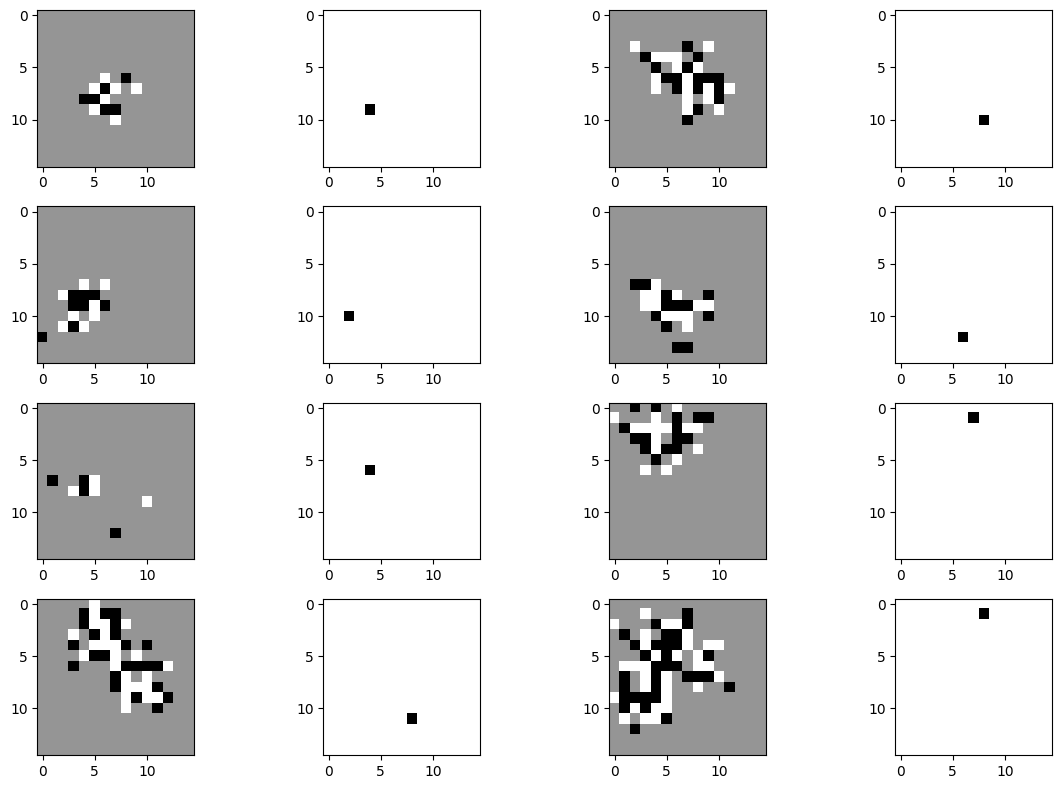

In [9]:
import matplotlib.pyplot as plt
count = 0
plt.figure(figsize=(12,8))
for n in range(8):
    count += 1
    plt.subplot(4, 4, count)
    plt.imshow(x_test[n].reshape(15, 15), cmap='Greys', interpolation='nearest')
    count += 1
    plt.subplot(4, 4, count)
    plt.imshow(y_test[n].reshape(15, 15), cmap='Greys', interpolation='nearest')

plt.tight_layout()
plt.show()

In [10]:
########################################################################################################################
# model = models.Sequential([
#     layers.Flatten(input_shape=(h, w, 1)),
#     layers.Dense(1024, activation='relu'),
#     layers.Dropout(0.4),
#     layers.Dense(1024, activation='relu'),
#     layers.Dense(225),
#     layers.Activation('softmax')
#     ])

# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',# binary_crossentropy, sparse_categorical_crossentropy
#     metrics=['accuracy']
# )

# model.summary()

########################################################################################################################
model = models.Sequential([
    layers.Conv2D(8, kernel_size=5, activation='relu', padding='same', input_shape=(h, w, 1)),
    layers.Conv2D(16, kernel_size=5, activation='relu', padding='same'),
    layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    layers.Dropout(0.1),

    layers.Conv2D(64, kernel_size=5, activation='relu', padding='same'),
    layers.Conv2D(128, kernel_size=5, activation='relu', padding='same'),
#     layers.Conv2D(256, kernel_size=7, activation='relu', padding='same'),
#     layers.Conv2D(128, kernel_size=7, activation='relu', padding='same'),
    layers.Conv2D(64, kernel_size=5, activation='relu', padding='same'),
    layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    layers.Conv2D(16, kernel_size=5, activation='relu', padding='same'),
    layers.Conv2D(8, kernel_size=5, activation='relu', padding='same'),
    layers.Conv2D(4, kernel_size=5, activation='relu', padding='same'),
    layers.Conv2D(1, 1, activation=None, padding='same'),
    
    layers.Dropout(0.1),
    layers.Conv2D(8, kernel_size=5, activation='relu', padding='same'),
    layers.Conv2D(16, kernel_size=5, activation='relu', padding='same'),
    layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    layers.Conv2D(16, kernel_size=5, activation='relu', padding='same'),
    layers.Conv2D(8, kernel_size=5, activation='relu', padding='same'),
    layers.Conv2D(1, 1, activation=None, padding='same'),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dropout(0.2),
#     layers.Dense(1000, activation='relu'),
    layers.Dense(225),
    layers.Activation('softmax')
    ])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',# binary_crossentropy, sparse_categorical_crossentropy
    metrics=['accuracy']
)

model.summary()
########################################################################################################################



# model = models.Sequential([
#     layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=(h, w, 1)),
#     layers.Conv2D(128, 7, activation='relu', padding='same'),
#     layers.Conv2D(256, 7, activation='relu', padding='same'),
#     layers.Conv2D(128, 7, activation='relu', padding='same'),
#     layers.Conv2D(64, 7, activation='relu', padding='same'),
#     layers.Conv2D(1, 1, activation=None, padding='same'),
#     layers.Reshape((h * w,)),
#     layers.Activation('softmax')
# ])

# model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['acc']
# )

# model.summary()
########################################################################################################################

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 8)         208       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 16)        3216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        12832     
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       204928    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 64)        2

## model plot

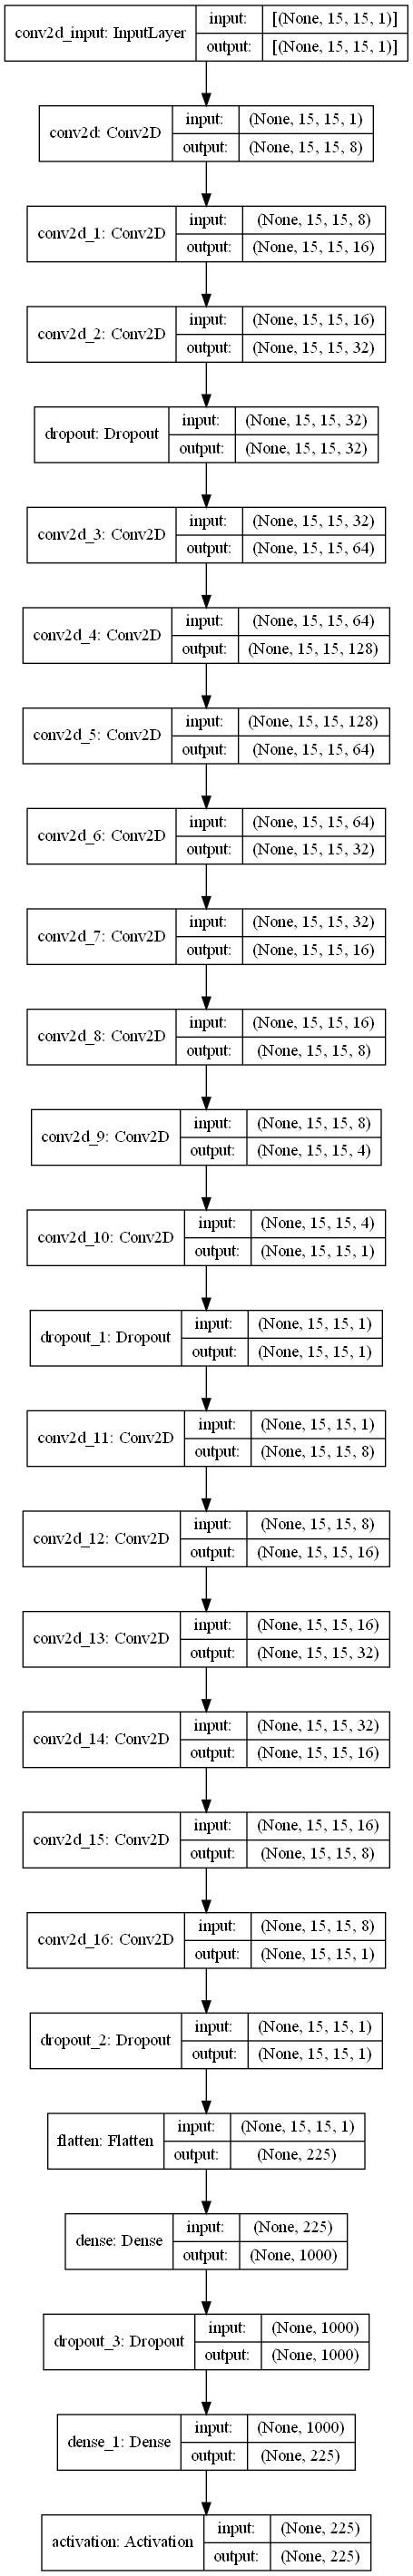

In [11]:
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

### 정확도(Accuracy)
 - 전체 데이터에 대한 예측 오류의 수
 
### 손실(Loss)
 - 실제 정답과 모델이 예측 한 값 사이의 차이

In [12]:
# start_time = datetime.now().strftime('%Y%m%d_%H%M%S')
# os.makedirs('models', exist_ok=True)

# history = model.fit(
#     x=x_train,
#     y=y_train,
#     batch_size=64,
#     epochs=40,
#     shuffle=True,
#     callbacks=[
#         ModelCheckpoint('./models/%s.h5' % (start_time), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
#         ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, verbose=1, mode='auto'),
#         EarlyStopping(monitor='val_accuracy', patience=5)
#     ],
#     validation_data=(x_val, y_val),
#     use_multiprocessing=True,
#     workers=32
# ) # epoch 40 -> accuracy: 0.85
########################################################################################################################
start_time = datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs('models', exist_ok=True)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=30,
    shuffle=True,
    callbacks=[
        ModelCheckpoint('./models/%s.h5' % (start_time), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_accuracy', patience=5)
    ],
    validation_data=(x_val, y_val),
    use_multiprocessing=True,
    workers=32
)
########################################################################################################################

Epoch 1/30
21502/21502 [==============================] - 432s 20ms/step - loss: 0.0247 - accuracy: 0.1275 - val_loss: 0.0132 - val_accuracy: 0.4526

Epoch 00001: val_accuracy improved from -inf to 0.45262, saving model to ./models\20221013_122734.h5
Epoch 2/30
21502/21502 [==============================] - 430s 20ms/step - loss: 0.0134 - accuracy: 0.4493 - val_loss: 0.0118 - val_accuracy: 0.4952

Epoch 00002: val_accuracy improved from 0.45262 to 0.49522, saving model to ./models\20221013_122734.h5
Epoch 3/30
21502/21502 [==============================] - 432s 20ms/step - loss: 0.0121 - accuracy: 0.4881 - val_loss: 0.0111 - val_accuracy: 0.5124

Epoch 00003: val_accuracy improved from 0.49522 to 0.51245, saving model to ./models\20221013_122734.h5
Epoch 4/30
21502/21502 [==============================] - 449s 21ms/step - loss: 0.0114 - accuracy: 0.5080 - val_loss: 0.0107 - val_accuracy: 0.5243

Epoch 00004: val_accuracy improved from 0.51245 to 0.52429, saving model to ./models\202210

In [13]:
i = 10
for y in range(h):
    for x in range(w):
        print('%2d' % x_test[i][y, x], end='')
    print()

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0-1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0-1 0 0 0 0
 0 0 0 0 0-1 0 1-1 1 0 0 0 0 0
 0 0 0 0 0 0 1-1 0 0 0 0 1 0 0
 0 0 0 0 0-1-1 1 1-1 0-1 1 0 0
 0 0 0 0 1 1 1-1 1 1-1-1-1 0 0
 0 0 1 0 0-1 1-1-1-1 1 1 1 0 0
 0 0 0-1 0-1 1-1-1 1 0 0 0 0 0
 0 0 0 0 0 0 1 1 1-1 0-1 0 0 0
 0 0 0 0 0 1-1-1-1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [14]:
print(history.history.keys())

NameError: name 'history' is not defined

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Trend') # trend -> 경향, 방향
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'], loc='best')
plt.grid()
plt.show()

NameError: name 'history' is not defined

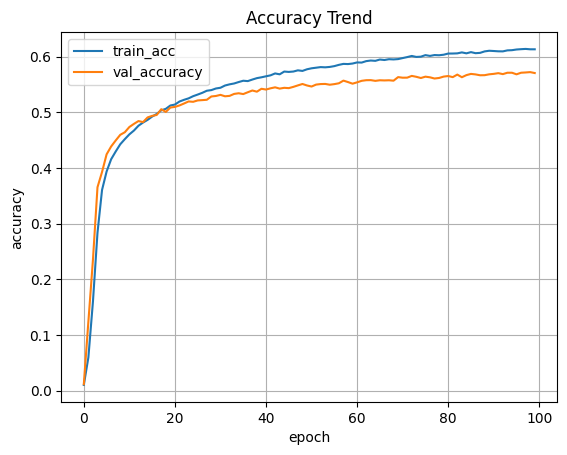

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Trend') # trend -> 경향, 방향
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_acc', 'val_accuracy'], loc='best')
plt.grid()
plt.show()

In [14]:
i = 10
for y in range(h):
    for x in range(w):
        print('%2d' % x_val[i][y, x], end='')
    print()

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [15]:
# y_pred = model.predict(np.expand_dims(x_val[i], axis=0)).squeeze()
# y_pred = y_pred.reshape((h, w))

# y, x = np.unravel_index(np.argmax(y_pred), y_pred.shape)

# print(x, y, y_pred[y, x])

print(f"x_val[1].shpae = {x_val[1].shape}")

input_1 = model.predict(np.expand_dims(x_val[i], axis=0)).squeeze()
# print(x_val[1])
# input_1 = np.expand_dims(x_val[1], axis=0).astype(np.float32)
print(f"input_1.shpae = {input_1.shape}")
output2 = np.argmax(input_1)
print(f"predict = {input_1[output2]}")
print(output2)
print(f"{output2//15}, {output2%15}") # y, x

x_val[1].shpae = (15, 15, 1)
input_1.shpae = (225,)
predict = 0.24853526055812836
112
7, 7


In [19]:
i = 12

input_1 = model.predict(np.expand_dims(x_val[i], axis=0)).squeeze()
# y_, x_ = np.unravel_index(np.argmax(input_1), x_val[i].shape)
output2 = np.argmax(input_1)
y_, x_ = output2//15, output2%15
print(f"x_val[1].shape = {x_val[1].shape}")
print(f"predict = {input_1[output2]}")
print(f"y_, x_ => {y_},{x_}")

a = ""
for y in range(h):
    for x in range(w):
        if y == y_ and x == x_:
            a += ' 7'
        else:
            a += str('%2d' % x_val[i][y, x])
    print(a)
    a = ""

x_val[1].shape = (15, 15, 1)
predict = 0.2042323350906372
y_, x_ => 8,2
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1-1-1 0 0 0 0 0 0 0 0 0
 0 0 1-1 1 1 0-1-1 0 0 0 0 0 0
 0 0 0 1-1 1 1 0 0-1 0 0 0 0 0
 0 0 0-1-1 1-1 1 0 0 0 0 0 0 0
 0 0 0 0 1 0-1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [24]:
input_1 = input_1.reshape((h, w))
print(f"input_1 -> shape {input_1.shape}")
y, x = np.unravel_index(np.argmax(input_1), input_1.shape)
print(f"y, x => {y},{x}")

input_1 -> shape (15, 15)
y, x => 11,9


In [25]:
y_pred = model.predict(np.expand_dims(x_val[i], axis=0)).squeeze()
print(y_pred.shape)
y_pred = y_pred.reshape((h, w))
y, x = np.unravel_index(np.argmax(y_pred), y_pred.shape)
print(y, x)
print(x, y, y_pred[y, x])

(225,)
11 9
9 11 0.98329306


In [26]:
print(np.argmax(y_pred))
print(y_pred.shape)

174
(15, 15)


In [23]:
# results = model.evaluate(x_val, y_val)
results = model.evaluate(x_test, y_test)

738/738 [==============================] - 4s 5ms/step - loss: 0.0104 - accuracy: 0.6876


In [24]:
print('val accuracy: ', results[1])

val accuracy:  0.6875582337379456


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('C:/JupyterProject/models/20220720_232252.h5')

In [ ]:
board_array = np.zeros((20, 20), dtype=np.int)
input_1 = board_array.copy()


In [ ]:
input_1 = np.expand_dims(input_1, axis=(0, -1)).astype(np.float32)

In [ ]:
output = model.predict(input_1).squeeze()

In [ ]:
output = output.reshape((20, 20))
output_y, output_x = np.unravel_index(np.argmax(output), output.shape)
print(f"y->{output_y}, x->{output_x}")